In [1]:
import mlflow

### Question 1: Version of MLflow

In [4]:
print(f"The installed MLfLow has version {mlflow.__version__}")

The installed MLfLow has version 2.3.2


In [5]:
import os
import urllib.request
import urllib.parse

url_list = [
    "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2022-01.parquet",
    "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2022-02.parquet",
    "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2022-03.parquet"
]

folder = "data"

if not os.path.exists(folder):
    os.makedirs(folder)

for url in url_list:
    parsed_url = urllib.parse.urlparse(url)
    filename = parsed_url.path.split("/")[-1]
    file_path = os.path.join(folder, filename)
    urllib.request.urlretrieve(url, file_path)
    print(f"Download {filename} to {file_path}")

Download green_tripdata_2022-01.parquet to data\green_tripdata_2022-01.parquet
Download green_tripdata_2022-02.parquet to data\green_tripdata_2022-02.parquet
Download green_tripdata_2022-03.parquet to data\green_tripdata_2022-03.parquet


In [6]:
data_path = "data"
output_path = "output"

In [7]:
%run experiment_tracking_homework/preprocess_data.py --raw_data_path {data_path} --dest_path {output_path}

### Question 2: Size of the DictVectorizer file


In [8]:
file_list = [file for file in os.listdir(output_path) if file.endswith(".pkl")]

for file in file_list:
    file_path = os.path.join(output_path, file)
    file_size = os.path.getsize(file_path)
    print(f"Size of {file} is {file_size} bytes")

Size of dv.pkl is 153660 bytes
Size of test.pkl is 2632817 bytes
Size of train.pkl is 2146163 bytes
Size of val.pkl is 2336393 bytes


Run the mlflow by run this command
```bash
mlflow ui --backend-store-uri sqlite:///mlflow.db
```

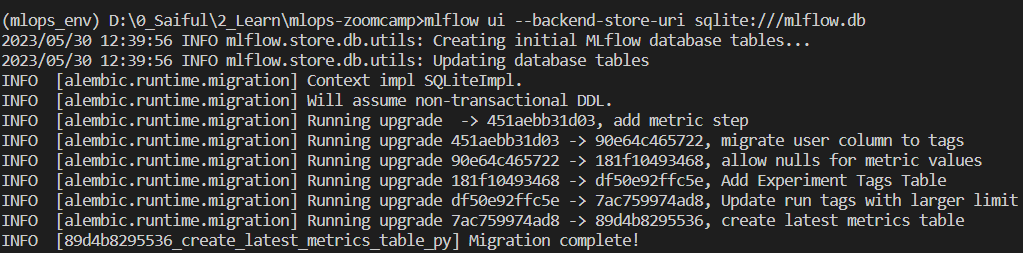

In [2]:
%run experiment_tracking_homework/train.py --data_path ./output

2023/05/30 13:04:35 INFO mlflow.tracking.fluent: Experiment with name 'homework-2' does not exist. Creating a new experiment.


Edited train.py

```python
import os
import pickle
import click
import mlflow

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_experiment('homework-2')


def load_pickle(filename: str):
    with open(filename, "rb") as f_in:
        return pickle.load(f_in)


@click.command()
@click.option(
    "--data_path",
    default="./output",
    help="Location where the processed NYC taxi trip data was saved"
)
def run_train(data_path: str):

    with mlflow.start_run():

        mlflow.set_tag("model", "RandomForestRegressor")
        mlflow.set_tag("dataset", "NYC taxi")
        mlflow.set_tag("task", "regression")
        mlflow.set_tag("project", "homework 2")
        mlflow.sklearn.autolog()

        X_train, y_train = load_pickle(os.path.join(data_path, "train.pkl"))
        X_val, y_val = load_pickle(os.path.join(data_path, "val.pkl"))

        mlflow.log_param("train-data-path", os.path.join(data_path, "train.pkl"))
        mlflow.log_param("val-data-path", os.path.join(data_path, "val.pkl"))

        rf = RandomForestRegressor(max_depth=10, random_state=0)
        # mlflow.log_param("max_depth", 10)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)

        rmse = mean_squared_error(y_val, y_pred, squared=False)
        # mlflow.log_metric("rmse", rmse)


if __name__ == '__main__':
    run_train()

```

Some notes:
- If I set tracking URI to default (not explicitly writing in code), run mlflow ui without flag `--backend-store-uri`
```bash
mlflow ui
```
- run it in the same directory I run this notebook.

### Question 4: RMSE with hyperopt

In [1]:
%run experiment_tracking_homework/hpo.py

2023/05/30 21:21:09 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2023/05/30 21:21:09 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

In [4]:
%run experiment_tracking_homework/hpo.py

[I 2023-05-30 21:38:15,655] A new study created in memory with name: no-name-0a7064e9-065c-4241-b9e5-76dda8531d43
[I 2023-05-30 21:38:19,380] Trial 0 finished with value: 2.451379690825458 and parameters: {'n_estimators': 25, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 3}. Best is trial 0 with value: 2.451379690825458.
[I 2023-05-30 21:38:19,887] Trial 1 finished with value: 2.4667366020368333 and parameters: {'n_estimators': 16, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 0 with value: 2.451379690825458.
[I 2023-05-30 21:38:23,005] Trial 2 finished with value: 2.449827329704216 and parameters: {'n_estimators': 34, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 4}. Best is trial 2 with value: 2.449827329704216.
[I 2023-05-30 21:38:24,216] Trial 3 finished with value: 2.460983516558473 and parameters: {'n_estimators': 44, 'max_depth': 5, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 2 with value: 2.44982732

### Question 5: RMSE on test

In [13]:
%run experiment_tracking_homework/register_model.py

Registered model 'nyc-taxi-random-forest-model' already exists. Creating a new version of this model...
2023/05/31 02:52:08 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: nyc-taxi-random-forest-model, version 3
Created version '3' of model 'nyc-taxi-random-forest-model'.


For quetsion 5 I still get the test RMSE 2.285